### Problem 1 (50 points) 

Vapor-liquid equilibria data are correlated using two adjustable parameters $A_{12}$ and $A_{21}$ per binary
mixture. For low pressures, the equilibrium relation can be formulated as:

$$
\begin{aligned}
p = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Here the saturation pressures are given by the Antoine equation

$$
\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3},
$$

where $T = 20$($^{\circ}{\rm C}$) and $a_{1,2,3}$ for a water - 1,4 dioxane
system is given below.

|             | $a_1$     | $a_2$      | $a_3$     |
|:------------|:--------|:---------|:--------|
| Water       | 8.07131 | 1730.63  | 233.426 |
| 1,4 dioxane | 7.43155 | 1554.679 | 240.337 |


The following table lists the measured data. Recall that in a binary system $x_1 + x_2 = 1$.

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |

Estimate $A_{12}$ and $A_{21}$ using data from the above table: 

1. Formulate the least square problem; 
2. Since the model is nonlinear, the problem does not have an analytical solution. Therefore, solve it using the gradient descent or Newton's method implemented in HW1; 
3. Compare your optimized model with the data. Does your model fit well with the data?

---

### Problem 2 (50 points) 

Solve the following problem using Bayesian Optimization:
$$
    \min_{x_1, x_2} \quad \left(4-2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + \left(-4 + 4x_2^2\right)x_2^2,
$$
for $x_1 \in [-3,3]$ and $x_2 \in [-2,2]$. A tutorial on Bayesian Optimization can be found [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).





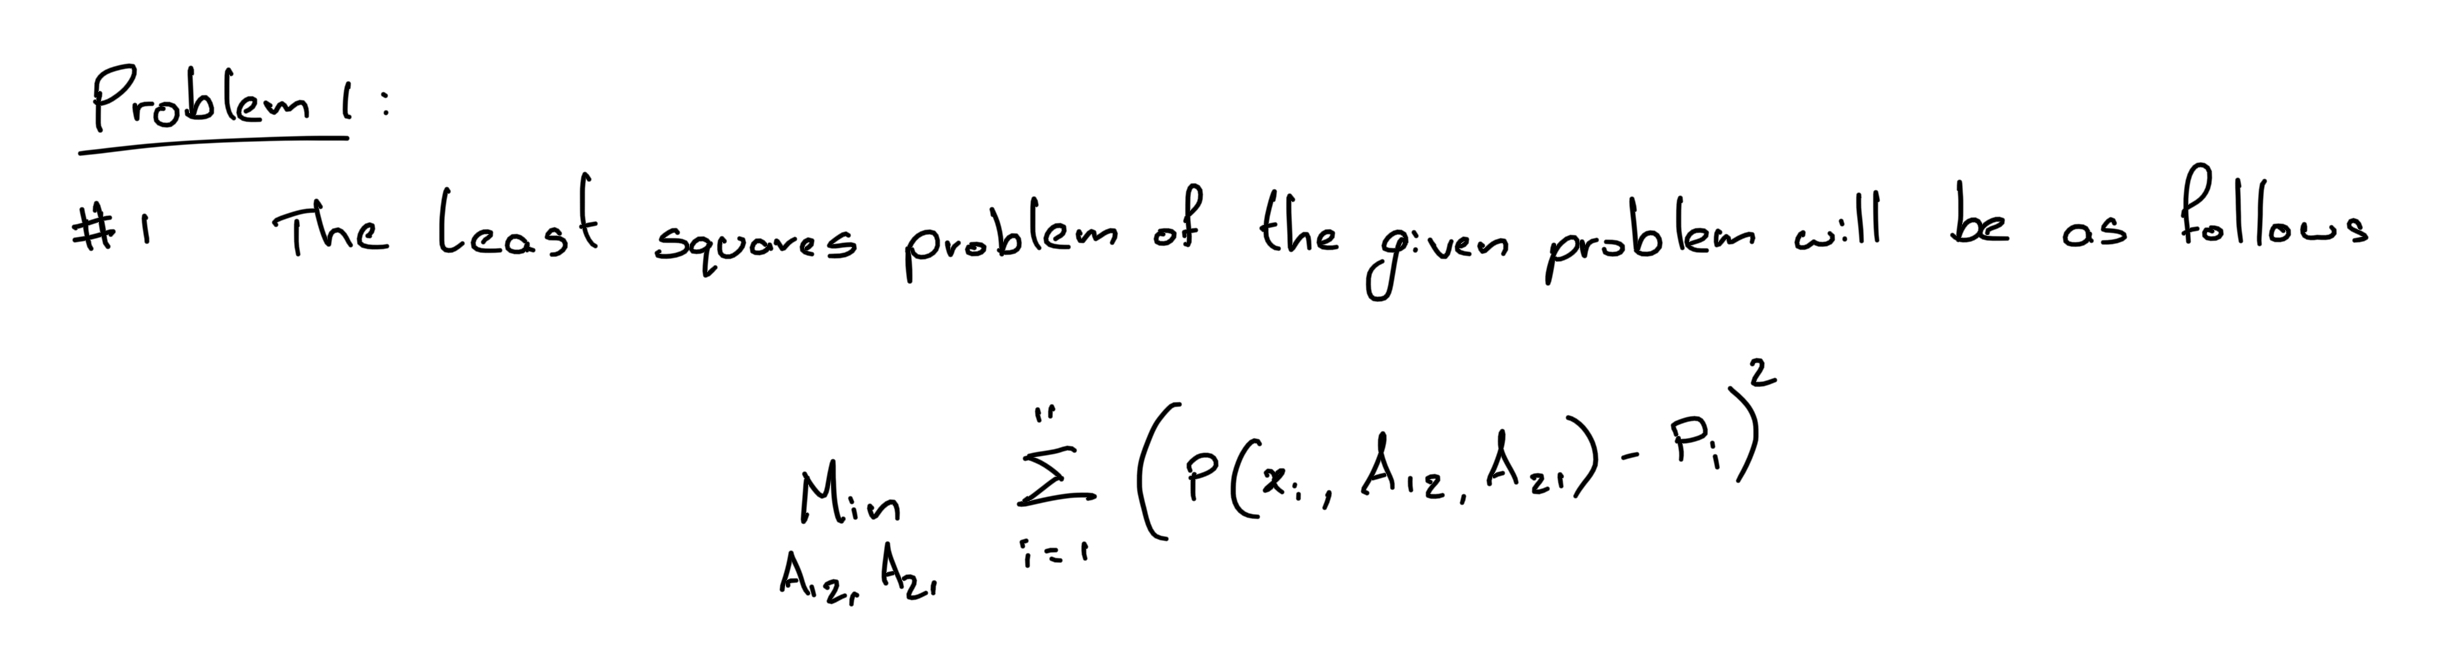

In [ ]:
#2
import numpy as np
def psat(i):
    t=20
    a1=8.07131,7.43155
    a2=1730.63,1554.679
    a3=233.426,240.337
    power=(np.log(10)*(a1[i]-(a2[i]/(t+a3[i]))))
    return np.exp(power)
p_wsat=psat(0)
p_dsat=psat(1)
print(p_wsat,p_dsat)

17.47325208459706 28.82409952740525


In [ ]:
import torch as t
from torch.autograd import Variable
def eqp(a):
  x1 = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
  p = [28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5]
  total_sum = 0.0
  for i in range(11):
      t1 = x1[i]*p_wsat*t.exp(a[0]*(a[1]*(1-x1[i])/(a[0]*x1[i]+a[1]*(1-x1[i])))**2)
      t2 = (1-x1[i])*p_dsat*t.exp(a[1]*(a[0]*x1[i]/(a[0]*x1[i]+a[1]*(1-x1[i])))**2)
      total_sum = total_sum + (t1+t2-p[i])**2
  return total_sum

In [ ]:
error = 1
x = Variable(t.tensor([1.0,1.0]), requires_grad = True)
while error>= 0.05:
    eqp(x).backward()
    error = t.linalg.norm(x.grad)
    s = .2
    while eqp(x-s*x.grad) > eqp(x):
        s = .5*s
    with t.no_grad():
        x -= s*x.grad
        x.grad.zero_()
ans=x
print(x)
print(eqp(x))

tensor([1.9582, 1.6893], requires_grad=True)
tensor(0.6702, grad_fn=<AddBackward0>)


In [ ]:
# Without line search

import torch as t
from torch.autograd import Variable

x = Variable(t.tensor([1.0, 1.0]), requires_grad=True)

# Fix the step size
a = 0.01

# Start gradient descent
for i in range(1000):  # TODO: change the termination criterion
    loss = eqp(x)
    loss.backward()
    
    # no_grad() specifies that the operations within this context are not part of the computational graph, i.e., we don't need the gradient descent algorithm itself to be differentiable with respect to x
    with t.no_grad():
        x -= a * x.grad
        
        # need to clear the gradient at every step, or otherwise it will accumulate...
        x.grad.zero_()
        
print(x.data.numpy())
print(loss.data.numpy())

[-343.05765 -502.0385 ]
10885.601


In [ ]:
# With line search

import torch as t
from torch.autograd import Variable
x = Variable(t.tensor([1.0, 1.0]), requires_grad=True)        
loss=eqp(x)
loss.backward()
soln=[x]
error=t.linalg.norm(x.grad)
a=0.01
eps=1e-3

def line_search(x,d):
  a=1
  def phi(a,x,d):
    return eqp(x)+a*0.8*np.dot(x.grad,d)

  while phi(a,x,d)<eqp(x+a*d):
    a=0.5*a
  
  return a

while error>=eps:
  d=-x.grad
  a=line_search(x,d)
  x=x+a*d
  soln.append(x)
  error=t.linalg.norm(x.grad)

print(soln)
# print(x.data.numpy())
print(loss.data.numpy())
print(x.grad)

In [ ]:
#3
x1 = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
p = [28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5]
a = ans
print("The following errors arises with each of the given values")
for i in range(11):
  t1 = x1[i]*p_wsat*t.exp(a[0]*(a[1]*(1-x1[i])/(a[0]*x1[i]+a[1]*(1-x1[i])))**2)
  t2 = (1-x1[i])*p_dsat*t.exp(a[1]*(a[0]*x1[i]/(a[0]*x1[i]+a[1]*(1-x1[i])))**2)
  print((t1+t2-p[i])/p[i])
  

The following errors arises with each of the given values
tensor(0.0258, grad_fn=<DivBackward0>)
tensor(0.0071, grad_fn=<DivBackward0>)
tensor(-0.0068, grad_fn=<DivBackward0>)
tensor(-0.0009, grad_fn=<DivBackward0>)
tensor(0.0020, grad_fn=<DivBackward0>)
tensor(0.0013, grad_fn=<DivBackward0>)
tensor(-0.0030, grad_fn=<DivBackward0>)
tensor(-0.0004, grad_fn=<DivBackward0>)
tensor(0.0015, grad_fn=<DivBackward0>)
tensor(0.0011, grad_fn=<DivBackward0>)
tensor(-0.0015, grad_fn=<DivBackward0>)


In [ ]:
#Problem 2
#The code for the Bayesian optimisation of loss fuction is taken form the git "https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py" of the given tutorial link
import numpy as np
import sklearn.gaussian_process as gp
from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [ ]:
f = lambda x: (4.0-2.1*x[0]**2+x[0]**4/3.0)*x[0]**2+x[0]*x[1]+(-4+4*x[1]**2)*x[1]**2
x, y = bayesian_optimisation(50, sample_loss=f, bounds=np.array([[-3, 3], [-2, 2]]), x0=None, n_pre_samples=10, gp_params=None, random_search=10, alpha=1e-5, epsilon=1e-7)
print('The minimal value is ' + str(np.min(y)))
print('The values of x1 and x2 are ' + str(x[np.where(y == np.amin(y))]))

The minimal value is -0.8201094801779634
The values of x1 and x2 are [[-0.1363391  -0.73430221]]
